# Oversampling on class regrouping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.pipeline import make_pipeline

import warnings

# suppress warning from MLP

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

resource_folder = 'res'


Importing datasets manually

In [ ]:
df_red = pd.read_csv(f'{resource_folder}/winequality-red.csv', sep=';')
df_red

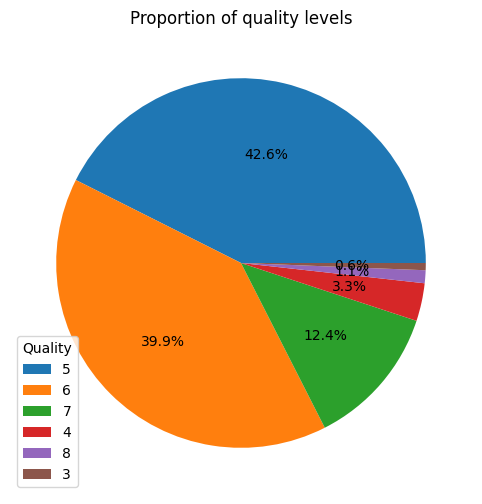

In [30]:
y = df_red['quality']
count = y.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

i'm applying oversampling to the red dataset so it does not have a lot less values than white

I concatenate the red and white datasets to have a single one

## Regrouping the target classes

3--4 $\rightarrow$ 1;   
5 $\rightarrow$ 2;  
6 $\rightarrow$ 3;  
7--8--9 $\rightarrow$ 4;    



In [31]:
df_red['quality'] = df_red['quality'].replace({
    3: 1, 4: 1,
    5: 2,
    6: 3,
    7: 4, 8: 4, 9: 4
})


In [32]:
# Use smote to balance the dataset
X = df_red.drop('quality', axis=1)
y = df_red['quality']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='quality')

df_red = pd.concat([X_resampled, y_resampled], axis=1)
df_red['quality'].value_counts()


quality
2    681
3    681
4    681
1    681
Name: count, dtype: int64

## Expolaratory Data analysis

We start with a pie chart to look at the proportion of quality levels

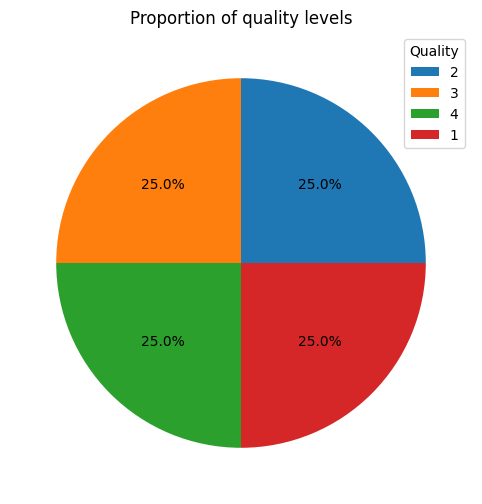

In [33]:
y = df_red['quality']
count = y.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

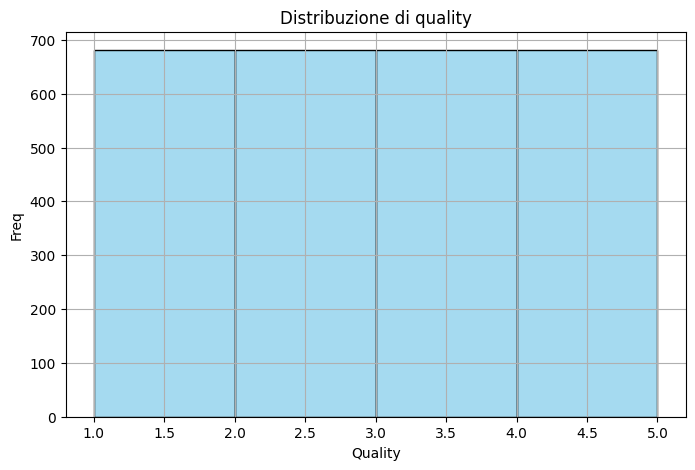

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(df_red['quality'], bins=range(df_red['quality'].min(), df_red['quality'].max()+2), color='skyblue')
plt.title("Distribuzione di quality")
plt.xlabel("Quality")
plt.ylabel("Freq")
plt.grid(True)
plt.show()

It is a good distribution, thus i'll try first without oversampling

In [35]:
X = df_red.drop(columns='quality')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle= True)

X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1652,10.075274,0.931146,0.219564,3.382546,0.104825,11.000000,85.840009,1.000947,3.426655,0.639273,11.269456
2067,7.505087,0.730363,0.044673,3.043823,0.078576,13.992732,27.489099,0.996529,3.389855,0.489782,10.344549
999,6.400000,0.690000,0.000000,1.650000,0.055000,7.000000,12.000000,0.991620,3.470000,0.530000,12.900000
2386,5.600000,0.660000,0.000000,2.200000,0.087000,3.000000,11.000000,0.993780,3.710000,0.630000,12.800000
700,10.600000,1.020000,0.430000,2.900000,0.076000,26.000000,88.000000,0.998400,3.080000,0.570000,10.100000
...,...,...,...,...,...,...,...,...,...,...,...
1638,6.895087,0.541720,0.000000,2.177232,0.065406,6.772318,13.772318,0.995505,3.443260,0.586830,10.695087
1095,9.400000,0.400000,0.470000,2.500000,0.087000,6.000000,20.000000,0.997720,3.150000,0.500000,10.500000
1130,9.100000,0.600000,0.000000,1.900000,0.058000,5.000000,10.000000,0.997700,3.180000,0.630000,10.400000
1294,8.200000,0.635000,0.100000,2.100000,0.073000,25.000000,60.000000,0.996380,3.290000,0.750000,10.900000


# EXPERIMENTS
We start by looking at the best performing models w/o optmization.
First we load the models

In [36]:
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier()
}

We then scale the sets

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

And now we train all the models to select the best permorming ones.

In [ ]:
results = {}

for name, model in models.items():
    if name == 'Decision Tree':

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
    else:

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        results[name] = acc


# sort the map results by accuracy
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
results

{'MLP': 0.7559633027522936,
 'Decision Tree': 0.710091743119266,
 'SVM': 0.6770642201834862,
 'Logistic Regression': 0.5614678899082569}

In [39]:
# code to take only the first 2 models
top_models = list(results.keys()) #[:2]

Since we only found accuracy >= 0.6 for mlp and decision trees we are going to grid search only on those

In [40]:
param_grids = {
    'MLP': {
        'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'mlpclassifier__alpha': [0.0001, 0.001]
    },
    'SVM': {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__penalty': ['l2', 'l1'],
        'logisticregression__solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}


In [41]:

# i wanto to pop the key that there aren't in the top_models
for model in list(param_grids.keys()):
    if model not in top_models:
        param_grids.pop(model)

param_grids

{'MLP': {'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
  'mlpclassifier__alpha': [0.0001, 0.001]},
 'SVM': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
 'Logistic Regression': {'logisticregression__C': [0.1, 1, 10],
  'logisticregression__penalty': ['l2', 'l1'],
  'logisticregression__solver': ['liblinear']},
 'Decision Tree': {'max_depth': [None, 10, 20],
  'min_samples_split': [2, 5, 10]}}

Here we train using gridsearch (and also RFE for decision trees)

In [ ]:
models = {
    'MLP': make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000)),
    'SVM': make_pipeline(StandardScaler(), SVC()),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'Decision Tree': DecisionTreeClassifier()
}

# Grid Search con tqdm
best_models = {}
for name in tqdm(param_grids.keys(), desc="Grid search", total=len(param_grids)):

    print(f"\nEseguo GridSearch per: {name}")
    model = models[name]
    grid = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, verbose=0)
    grid.fit(X, y)
    best_models[name] = grid.best_params_
    print(f"Migliori parametri per {name}: {grid.best_params_}")
    print(f"Score: {grid.best_score_:.4f}")

best_models


Grid search:   0%|          | 0/4 [00:00<?, ?it/s]


Eseguo GridSearch per: MLP


Grid search:  25%|██▌       | 1/4 [01:41<05:04, 101.53s/it]

Migliori parametri per MLP: {'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (100, 50)}
Score: 0.7188

Eseguo GridSearch per: SVM


Grid search:  50%|█████     | 2/4 [01:46<01:29, 44.65s/it] 

Migliori parametri per SVM: {'svc__C': 10, 'svc__kernel': 'rbf'}
Score: 0.7030

Eseguo GridSearch per: Logistic Regression


Grid search:  75%|███████▌  | 3/4 [01:46<00:24, 24.48s/it]

Migliori parametri per Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Score: 0.5730

Eseguo GridSearch per: Decision Tree


Grid search: 100%|██████████| 4/4 [01:47<00:00, 26.85s/it]

Migliori parametri per Decision Tree: {'max_depth': 20, 'min_samples_split': 5}
Score: 0.6248


{'MLP': {'mlpclassifier__alpha': 0.0001,
  'mlpclassifier__hidden_layer_sizes': (100, 50)},
 'SVM': {'svc__C': 10, 'svc__kernel': 'rbf'},
 'Logistic Regression': {'logisticregression__C': 10,
  'logisticregression__penalty': 'l2',
  'logisticregression__solver': 'liblinear'},
 'Decision Tree': {'max_depth': 20, 'min_samples_split': 5}}

In [43]:
# instancing the model with the best parameters
accuracies = {}

for model_name in top_models:
    match model_name:
        case 'Decision Tree':
            tuned_model = DecisionTreeClassifier(**best_models[model_name])
        case 'MLP':
            tuned_model = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000))
            tuned_model.set_params(**best_models[model_name])
        case 'SVM':
            tuned_model = make_pipeline(StandardScaler(), SVC())
            tuned_model.set_params(**best_models[model_name])
        case 'Logistic Regression':
            tuned_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
            tuned_model.set_params(**best_models[model_name])
    
    tuned_model.fit(X_train, y_train)
    y_pred = tuned_model.predict(X_test)
    accuracies[model_name] = accuracy_score(y_test, y_pred)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

# Sort accuracies
accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))
print("\nAccuracies of the tuned models:")
for model_name, accuracy in accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")


Classification Report for MLP:
              precision    recall  f1-score   support

           1       0.86      0.99      0.92       137
           2       0.74      0.64      0.69       144
           3       0.63      0.60      0.61       136
           4       0.84      0.89      0.87       128

    accuracy                           0.77       545
   macro avg       0.77      0.78      0.77       545
weighted avg       0.77      0.77      0.77       545


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1       0.76      0.88      0.82       137
           2       0.65      0.59      0.62       144
           3       0.53      0.53      0.53       136
           4       0.82      0.78      0.80       128

    accuracy                           0.69       545
   macro avg       0.69      0.69      0.69       545
weighted avg       0.69      0.69      0.69       545


Classification Report for SVM:
              precision 

Best hyperparameters found so far: 

- 'mlpclassifier__solver': 'adam' 
- 'mlpclassifier__learning_rate_init': 0.001 
- 'mlpclassifier__learning_rate': 'constant' 
- 'mlpclassifier__hidden_layer_sizes': (128, 64) 
- 'mlpclassifier__alpha': np.float64(0.0017782794100389228)
- 'mlpclassifier__activation': 'relu'

params_mik = {
    'mlpclassifier__solver': 'adam', 
    'mlpclassifier__learning_rate_init': 0.001, 
    'mlpclassifier__learning_rate': 'constant', 
    'mlpclassifier__hidden_layer_sizes': (128, 64), 
    'mlpclassifier__alpha': np.float64(0.0017782794100389228), 
    'mlpclassifier__activation': 'relu'
}
    


In [ ]:
# Pipeline modello
pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=42))


local_param_grid = {
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__learning_rate_init': [0.0005, 0.001, 0.005],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
    'mlpclassifier__hidden_layer_sizes': [(128, 64), (100, 50), (128, 64, 32)],
    'mlpclassifier__alpha': np.logspace(-5, -2, 5),
    'mlpclassifier__activation': ['relu', 'tanh']
}

# Random search
search = GridSearchCV(pipeline, local_param_grid, cv=3, n_jobs=-1, verbose=10)

# Fit
search.fit(X, y)

# Risultati
print(f"\nMigliori parametri trovati: {search.best_params_}")
print(f"Score medio CV: {search.best_score_:.4f}")

Fitting 3 folds for each of 180 candidates, totalling 540 fits

Migliori parametri trovati: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': np.float64(0.00031622776601683794), 'mlpclassifier__hidden_layer_sizes': (128, 64, 32), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__learning_rate_init': 0.001, 'mlpclassifier__solver': 'adam'}
Score medio CV: 0.7221


### Best parameter found so far

- 'mlpclassifier__activation': 'relu'
- 'mlpclassifier__alpha': np.float64(0.00031622776601683794) # np.logspace(-5, -2, 5)
- 'mlpclassifier__hidden_layer_sizes': (128, 64, 32)
- 'mlpclassifier__learning_rate': 'constant'
- 'mlpclassifier__learning_rate_init': 0.001
- 'mlpclassifier__solver': 'adam'


In [92]:
# instancing MLP with best parameters
pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=2000, random_state=42))
pipeline.set_params(**search.best_params_)
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final model accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Final model accuracy: 0.8055
              precision    recall  f1-score   support

           1       0.90      0.96      0.93       137
           2       0.76      0.81      0.78       144
           3       0.73      0.54      0.62       136
           4       0.81      0.93      0.87       128

    accuracy                           0.81       545
   macro avg       0.80      0.81      0.80       545
weighted avg       0.80      0.81      0.80       545

